# CS 7641 HW1 Code - Unsupervised Learning

This file will provide analysis clustering and dimensionality reduction techniques for for two datasets.

Datasets: Phishing Websites, Bank Marketing.

Clustering Techniques: k-Means, Expectation Maximization.
Dimensionality Reduction Techniques: PCA, ICA, RCA, RFC

# 1. Data Load and Preprocessing

First we load the data! Please save the datasets to your local machine and change the current directory to a file where you have the data stored.

In [1]:
import os
import pandas as pd
import numpy as np
import random

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

os.chdir(r"C:\Users\Administrator\Assignment 3 Unsupervised Learning") #change this to your current working directory
#os.chdir(r"C:\Users\kwest18\Desktop\ML Code") #change this to your current working directory


### Load the Phishing Website Data

In [2]:
## Download the Phishing Data from OpenML https://www.openml.org/d/4534

df_phish = pd.read_csv('PhishingWebsitesData.csv').astype('category')
print("Data has",len(df_phish),"rows and", len(df_phish.columns),"columns.")
if df_phish.isnull().values.any():
    print("Warning: Missing Data")
#df_phish.head()
#df_phish.describe(include='all')

Data has 11055 rows and 31 columns.


Now that the phishing data is loaded, we need to do some preprocessing. Several of the columns are categorical with the levels {-1,0,1} and the rest are all binary with levels {-1,1}. For the 3-level columns we will use one-hot encoding to create additional features with level {0,1}. Finally, we will edit the binary features so that the new levels are all {0,1}. We will have more features now, but they will all be binary.

In [3]:
col_1hot = ['URL_Length','having_Sub_Domain','SSLfinal_State','URL_of_Anchor','Links_in_tags','SFH','web_traffic','Links_pointing_to_page']
df_1hot = df_phish[col_1hot]
df_1hot = pd.get_dummies(df_1hot)
df_others = df_phish.drop(col_1hot,axis=1)
df_phish = pd.concat([df_1hot,df_others],axis=1)
df_phish = df_phish.replace(-1,0).astype('category')
column_order = list(df_phish)
column_order.insert(0, column_order.pop(column_order.index('Result')))
df_phish = df_phish.loc[:, column_order]  #move the target variable 'Result' to the front
#df_phish.describe(include='all')

In [4]:
df_phish.to_csv("PhishingWebsitesData_preprocessed.csv")

We now have a file with no missing data in the format [y, X] where all features are binary {0,1}. The phishing data is ready to go! Now we move on to loading the Bank Marketing data.

### Load the Bank Marketing Data

In [5]:
## Load the Bank Marketing Data from OpenML https://www.openml.org/d/1461

df_bank = pd.read_csv('BankMarketingData.csv')
print("Data has",len(df_bank),"rows and", len(df_bank.columns),"columns.")
if df_bank.isnull().values.any():
    print("Warning: Missing Data")
#df_bank.head()
#df_bank.describe(include='all')

Data has 45307 rows and 21 columns.


This dataset needs some preprocessing love too. We will convert all categorical columns using one hot encoding. Additionally, we will standardize all of the numeric features and we will convert the target variable from {no,yes} to {0,1}. It should be noted that the feature 'pdays' is numeric but contains values that are '999' if the customer was not called before. It may be worth while to create a new feature that defines whether or not {0,1} a customer had been called before. In the current state the '999' values may be outliers. Finally we will standardize all numeric columns.

In [6]:
col_1hot = ['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
df_1hot = df_bank[col_1hot]
df_1hot = pd.get_dummies(df_1hot).astype('category')
df_others = df_bank.drop(col_1hot,axis=1)
df_bank = pd.concat([df_others,df_1hot],axis=1)
column_order = list(df_bank)
column_order.insert(0, column_order.pop(column_order.index('y')))
df_bank = df_bank.loc[:, column_order]
df_bank['y'].replace("no",0,inplace=True)
df_bank['y'].replace("yes",1,inplace=True)
df_bank['y'] = df_bank['y'].astype('category')

numericcols = ['age','duration','campaign','pdays','previous','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']
df_num = df_bank[numericcols]
df_stand =(df_num-df_num.min())/(df_num.max()-df_num.min())
df_bank_categorical = df_bank.drop(numericcols,axis=1)
df_bank = pd.concat([df_bank_categorical,df_stand],axis=1)
#df_bank.describe(include='all')

In [7]:
df_bank.to_csv("BankMarketingData_preprocessed.csv")

Now we have successfully loaded and processed both datasets. We are ready to start the ML!

# 2. Helper Functions

### Data Loading and Function Prep

Before we get into the algorithms, let's define some helper functions that will be used across all of the models and both datasets. We will define a function to load the data (not really necessary in a Jupyter notebook, but good if this is exported as a .py for later use). We will also define a function that plots the learning curve (training and cross validation score as a function of training examples) of an estimator (classification model). Finally, we define functions to output final model scores using an untouched test dataset.

In [8]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import itertools
import timeit
from collections import Counter
from sklearn.metrics.pairwise import pairwise_distances

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['font.size'] = 12

def import_data():

    X1 = np.array(df_phish.values[:,1:-1],dtype='int64')
    Y1 = np.array(df_phish.values[:,0],dtype='int64')
    X2 = np.array(df_bank.values[:,1:-1],dtype='int64')
    Y2 = np.array(df_bank.values[:,0],dtype='int64')
    return X1, Y1, X2, Y2


def plot_learning_curve(clf, X, y, title="Insert Title"):
    
    n = len(y)
    train_mean = []; train_std = [] #model performance score (f1)
    cv_mean = []; cv_std = [] #model performance score (f1)
    fit_mean = []; fit_std = [] #model fit/training time
    pred_mean = []; pred_std = [] #model test/prediction times
    train_sizes=(np.linspace(.05, 1.0, 20)*n).astype('int')  
    
    for i in train_sizes:
        idx = np.random.randint(X.shape[0], size=i)
        X_subset = X[idx,:]
        y_subset = y[idx]
        scores = cross_validate(clf, X_subset, y_subset, cv=10, scoring='f1', n_jobs=-1, return_train_score=True)
        
        train_mean.append(np.mean(scores['train_score'])); train_std.append(np.std(scores['train_score']))
        cv_mean.append(np.mean(scores['test_score'])); cv_std.append(np.std(scores['test_score']))
        fit_mean.append(np.mean(scores['fit_time'])); fit_std.append(np.std(scores['fit_time']))
        pred_mean.append(np.mean(scores['score_time'])); pred_std.append(np.std(scores['score_time']))
    
    train_mean = np.array(train_mean); train_std = np.array(train_std)
    cv_mean = np.array(cv_mean); cv_std = np.array(cv_std)
    fit_mean = np.array(fit_mean); fit_std = np.array(fit_std)
    pred_mean = np.array(pred_mean); pred_std = np.array(pred_std)
    
    plot_LC(train_sizes, train_mean, train_std, cv_mean, cv_std, title)
    plot_times(train_sizes, fit_mean, fit_std, pred_mean, pred_std, title)
    
    return train_sizes, train_mean, fit_mean, pred_mean
    

def plot_LC(train_sizes, train_mean, train_std, cv_mean, cv_std, title):
    
    plt.figure()
    plt.title("Learning Curve: "+ title)
    plt.xlabel("Training Examples")
    plt.ylabel("Model F1 Score")
    plt.fill_between(train_sizes, train_mean - 2*train_std, train_mean + 2*train_std, alpha=0.1, color="b")
    plt.fill_between(train_sizes, cv_mean - 2*cv_std, cv_mean + 2*cv_std, alpha=0.1, color="r")
    plt.plot(train_sizes, train_mean, 'o-', color="b", label="Training Score")
    plt.plot(train_sizes, cv_mean, 'o-', color="r", label="Cross-Validation Score")
    plt.legend(loc="best")
    plt.show()
    
    
def plot_times(train_sizes, fit_mean, fit_std, pred_mean, pred_std, title):
    
    plt.figure()
    plt.title("Modeling Time: "+ title)
    plt.xlabel("Training Examples")
    plt.ylabel("Training Time (s)")
    plt.fill_between(train_sizes, fit_mean - 2*fit_std, fit_mean + 2*fit_std, alpha=0.1, color="b")
    plt.fill_between(train_sizes, pred_mean - 2*pred_std, pred_mean + 2*pred_std, alpha=0.1, color="r")
    plt.plot(train_sizes, fit_mean, 'o-', color="b", label="Training Time (s)")
    plt.plot(train_sizes, pred_std, 'o-', color="r", label="Prediction Time (s)")
    plt.legend(loc="best")
    plt.show()
    
    
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(2), range(2)):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    
def final_classifier_evaluation(clf,X_train, X_test, y_train, y_test):
    
    start_time = timeit.default_timer()
    clf.fit(X_train, y_train)
    end_time = timeit.default_timer()
    training_time = end_time - start_time
    
    start_time = timeit.default_timer()    
    y_pred = clf.predict(X_test)
    end_time = timeit.default_timer()
    pred_time = end_time - start_time
    
    auc = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test,y_pred)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    cm = confusion_matrix(y_test,y_pred)

    print("Model Evaluation Metrics Using Untouched Test Dataset")
    print("*****************************************************")
    print("Model Training Time (s):   "+"{:.5f}".format(training_time))
    print("Model Prediction Time (s): "+"{:.5f}\n".format(pred_time))
    print("F1 Score:  "+"{:.2f}".format(f1))
    print("Accuracy:  "+"{:.2f}".format(accuracy)+"     AUC:       "+"{:.2f}".format(auc))
    print("Precision: "+"{:.2f}".format(precision)+"     Recall:    "+"{:.2f}".format(recall))
    print("*****************************************************")
    plt.figure()
    plot_confusion_matrix(cm, classes=["0","1"], title='Confusion Matrix')
    plt.show()

def cluster_predictions(Y,clusterLabels):
    assert (Y.shape == clusterLabels.shape)
    pred = np.empty_like(Y)
    for label in set(clusterLabels):
        mask = clusterLabels == label
        sub = Y[mask]
        target = Counter(sub).most_common(1)[0][0]
        pred[mask] = target
#    assert max(pred) == max(Y)
#    assert min(pred) == min(Y)    
    return pred

def pairwiseDistCorr(X1,X2):
    assert X1.shape[0] == X2.shape[0]
    
    d1 = pairwise_distances(X1)
    d2 = pairwise_distances(X2)
    return np.corrcoef(d1.ravel(),d2.ravel())[0,1]

## Neural Network Classifier

This section will build a forward-feed neural network which computes weights via backpropagation (a multilayer perceptron). The main hyperparameter will be number of hidden nodes in a network defined by a single hidden layer, while others that could be searched over in grid search are activation function, and learning rate. This will be used later when we compare neural networks built from different combinations of features after clustering and dimensionality reduction

In [9]:
from sklearn.neural_network import MLPClassifier

def hyperNN(X_train, y_train, X_test, y_test, title):

    f1_test = []
    f1_train = []
    hlist = np.linspace(1,150,30).astype('int')
    for i in hlist:         
            clf = MLPClassifier(hidden_layer_sizes=(i,), solver='adam', activation='logistic', 
                                learning_rate_init=0.05, random_state=100)
            clf.fit(X_train, y_train)
            y_pred_test = clf.predict(X_test)
            y_pred_train = clf.predict(X_train)
            f1_test.append(accuracy_score(y_test, y_pred_test))
            f1_train.append(accuracy_score(y_train, y_pred_train))
      
    plt.plot(hlist, f1_train, 'o-', color = 'b', label='Train Accuracy')
    plt.plot(hlist, f1_test, 'o-', color='r', label='Test Accuracy')
    plt.ylabel('Model Accuracy')
    plt.xlabel('No. Hidden Units')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    
    
def NNGridSearchCV(X_train, y_train):
    #parameters to search:
    #number of hidden units
    #learning_rate
    h_units = [5, 10, 20, 30, 40, 50, 75, 100]
    param_grid = {'hidden_layer_sizes': h_units}

    net = GridSearchCV(estimator = MLPClassifier(solver='adam',activation='logistic',learning_rate_init=0.05,random_state=100),
                       param_grid=param_grid, cv=10)
    net.fit(X_train, y_train)
    print("Per Hyperparameter tuning, best parameters are:")
    print(net.best_params_)
    return net.best_params_['hidden_layer_sizes']

# 3. Clustering

## k-Means Clustering

This section will implement k-means clustering for both datasets. Our objectives are to:
1. Determine the best number of clusters for each dataset by using the elbow inspection method on silhouette score.
2. Describe the attributes which make up each cluster.
3. Score each cluster with an accuracy since technically we do have labels available for these datasets (labels are not used when determining clusters).

Since k-Means is susceptible to get stuck in local optima due to the random selection of initial cluster centers, I will report the average metrics over 5 models for each number of k clusters.

In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score as sil_score, f1_score, homogeneity_score
import matplotlib.pyplot as plt

np.random.seed(0)

def run_kmeans(X,y,title):

    kclusters = list(np.arange(2,50,2))
    sil_scores = []; f1_scores = []; homo_scores = []; train_times = []

    for k in kclusters:
        start_time = timeit.default_timer()
        km = KMeans(n_clusters=k, n_init=10,random_state=100,n_jobs=-1).fit(X)
        end_time = timeit.default_timer()
        train_times.append(end_time - start_time)
        sil_scores.append(sil_score(X, km.labels_))
        y_mode_vote = cluster_predictions(y,km.labels_)
        f1_scores.append(f1_score(y, y_mode_vote))
        homo_scores.append(homogeneity_score(y, km.labels_))
        
    # elbow curve for silhouette score
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(kclusters, sil_scores)
    plt.grid(True)
    plt.xlabel('No. Clusters')
    plt.ylabel('Avg Silhouette Score')
    plt.title('Elbow Plot for KMeans: '+ title)
    plt.show()
   
    # plot homogeneity scores
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(kclusters, homo_scores)
    plt.grid(True)
    plt.xlabel('No. Clusters')
    plt.ylabel('Homogeneity Score')
    plt.title('Homogeneity Scores KMeans: '+ title)
    plt.show()

#     # plot f1 scores
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     ax.plot(kclusters, f1_scores)
#     plt.grid(True)
#     plt.xlabel('No. Clusters')
#     plt.ylabel('F1 Score')
#     plt.title('F1 Scores KMeans: '+ title)
#     plt.show()

#     # plot model training time
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     ax.plot(kclusters, train_times)
#     plt.grid(True)
#     plt.xlabel('No. Clusters')
#     plt.ylabel('Training Time (s)')
#     plt.title('KMeans Training Time: '+ title)
#     plt.show()
    
def evaluate_kmeans(km, X, y):
    start_time = timeit.default_timer()
    km.fit(X, y)
    end_time = timeit.default_timer()
    training_time = end_time - start_time
    
    y_mode_vote = cluster_predictions(y,km.labels_)
    auc = roc_auc_score(y, y_mode_vote)
    f1 = f1_score(y, y_mode_vote)
    accuracy = accuracy_score(y, y_mode_vote)
    precision = precision_score(y, y_mode_vote)
    recall = recall_score(y, y_mode_vote)
    cm = confusion_matrix(y, y_mode_vote)

    print("Model Evaluation Metrics Using Mode Cluster Vote")
    print("*****************************************************")
    print("Model Training Time (s):   "+"{:.2f}".format(training_time))
    print("No. Iterations to Converge: {}".format(km.n_iter_))
    print("F1 Score:  "+"{:.2f}".format(f1))
    print("Accuracy:  "+"{:.2f}".format(accuracy)+"     AUC:       "+"{:.2f}".format(auc))
    print("Precision: "+"{:.2f}".format(precision)+"     Recall:    "+"{:.2f}".format(recall))
    print("*****************************************************")
    plt.figure()
    plot_confusion_matrix(cm, classes=["0","1"], title='Confusion Matrix')
    plt.show()


Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   1.22
No. Iterations to Converge: 29
F1 Score:  0.87
Accuracy:  0.84     AUC:       0.82
Precision: 0.78     Recall:    0.99
*****************************************************


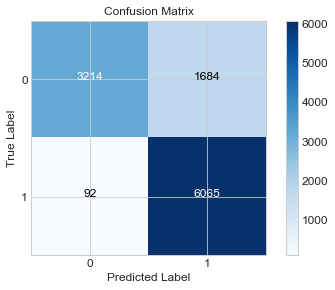

In [11]:
phishX,phishY,bankX,bankY = import_data()
#run_kmeans(phishX,phishY,'Phishing Data')
km = KMeans(n_clusters=9,n_init=10,random_state=100,n_jobs=-1)
evaluate_kmeans(km,phishX,phishY)
df = pd.DataFrame(km.cluster_centers_)
df.to_csv("Phishing kMeans Cluster Centers.csv")

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   11.85
No. Iterations to Converge: 32
F1 Score:  0.30
Accuracy:  0.90     AUC:       0.59
Precision: 0.65     Recall:    0.19
*****************************************************


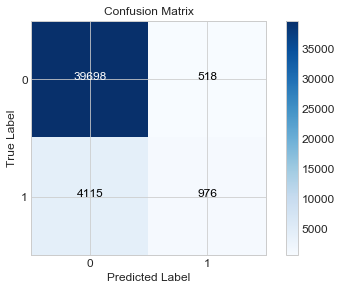

In [12]:
phishX,phishY,bankX,bankY = import_data()
#run_kmeans(bankX,bankY,'Banking Data')
km = KMeans(n_clusters=25,n_init=10,random_state=100,n_jobs=-1)
evaluate_kmeans(km,bankX,bankY)
df = pd.DataFrame(km.cluster_centers_)
df.to_csv("Banking kMeans Cluster Centers.csv")

## Expectation Maximization

This section will implement k-means clustering for both datasets. The same 3 objectives from k-means apply here.

In [13]:
from sklearn.mixture import GaussianMixture as EM
from sklearn.metrics import silhouette_score as sil_score, f1_score, homogeneity_score
import matplotlib.pyplot as plt

np.random.seed(0)

def run_EM(X,y,title):

    #kdist =  [2,3,4,5]
    #kdist = list(range(2,51))
    kdist = list(np.arange(2,100,5))
    sil_scores = []; f1_scores = []; homo_scores = []; train_times = []; aic_scores = []; bic_scores = []
    
    for k in kdist:
        start_time = timeit.default_timer()
        em = EM(n_components=k,covariance_type='diag',n_init=1,warm_start=True,random_state=100).fit(X)
        end_time = timeit.default_timer()
        train_times.append(end_time - start_time)
        
        labels = em.predict(X)
        sil_scores.append(sil_score(X, labels))
        y_mode_vote = cluster_predictions(y,labels)
        f1_scores.append(f1_score(y, y_mode_vote))
        homo_scores.append(homogeneity_score(y, labels))
        aic_scores.append(em.aic(X))
        bic_scores.append(em.bic(X))
        
    # elbow curve for silhouette score
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(kdist, sil_scores)
    plt.grid(True)
    plt.xlabel('No. Distributions')
    plt.ylabel('Avg Silhouette Score')
    plt.title('Elbow Plot for EM: '+ title)
    plt.show()
   
    # plot homogeneity scores
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(kdist, homo_scores)
    plt.grid(True)
    plt.xlabel('No. Distributions')
    plt.ylabel('Homogeneity Score')
    plt.title('Homogeneity Scores EM: '+ title)
    plt.show()

    # plot f1 scores
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(kdist, f1_scores)
    plt.grid(True)
    plt.xlabel('No. Distributions')
    plt.ylabel('F1 Score')
    plt.title('F1 Scores EM: '+ title)
    plt.show()

    # plot model AIC and BIC
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(kdist, aic_scores, label='AIC')
    ax.plot(kdist, bic_scores,label='BIC')
    plt.grid(True)
    plt.xlabel('No. Distributions')
    plt.ylabel('Model Complexity Score')
    plt.title('EM Model Complexity: '+ title)
    plt.legend(loc="best")
    plt.show()
    
def evaluate_EM(em, X, y):
    start_time = timeit.default_timer()
    em.fit(X, y)
    end_time = timeit.default_timer()
    training_time = end_time - start_time
    
    labels = em.predict(X)
    y_mode_vote = cluster_predictions(y,labels)
    auc = roc_auc_score(y, y_mode_vote)
    f1 = f1_score(y, y_mode_vote)
    accuracy = accuracy_score(y, y_mode_vote)
    precision = precision_score(y, y_mode_vote)
    recall = recall_score(y, y_mode_vote)
    cm = confusion_matrix(y, y_mode_vote)

    print("Model Evaluation Metrics Using Mode Cluster Vote")
    print("*****************************************************")
    print("Model Training Time (s):   "+"{:.2f}".format(training_time))
    print("No. Iterations to Converge: {}".format(em.n_iter_))
    print("Log-likelihood Lower Bound: {:.2f}".format(em.lower_bound_))
    print("F1 Score:  "+"{:.2f}".format(f1))
    print("Accuracy:  "+"{:.2f}".format(accuracy)+"     AUC:       "+"{:.2f}".format(auc))
    print("Precision: "+"{:.2f}".format(precision)+"     Recall:    "+"{:.2f}".format(recall))
    print("*****************************************************")
    plt.figure()
    plot_confusion_matrix(cm, classes=["0","1"], title='Confusion Matrix')
    plt.show()

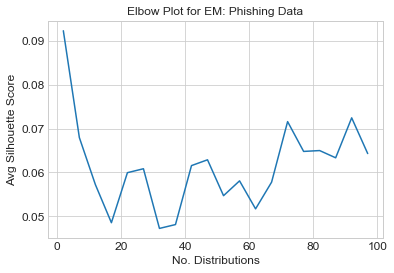

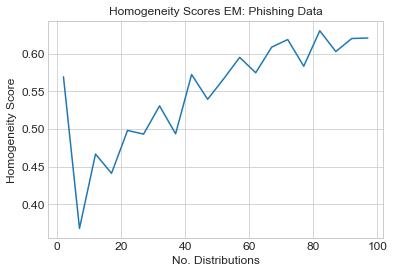

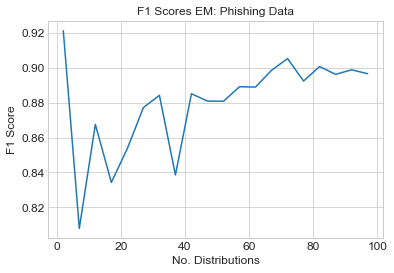

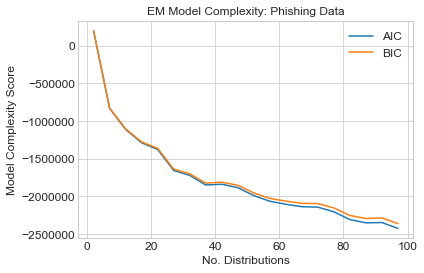

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   1.64
No. Iterations to Converge: 14
Log-likelihood Lower Bound: 66.57
F1 Score:  0.85
Accuracy:  0.83     AUC:       0.83
Precision: 0.83     Recall:    0.88
*****************************************************


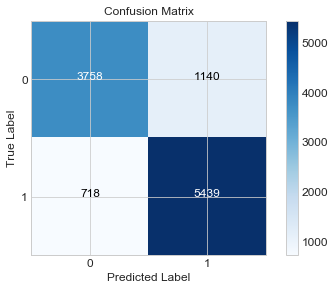

In [14]:
phishX,phishY,bankX,bankY = import_data()
run_EM(phishX,phishY,'Phishing Data')
em = EM(n_components=24,covariance_type='diag',n_init=1,warm_start=True,random_state=100)
evaluate_EM(em,phishX,phishY)
df = pd.DataFrame(em.means_)
df.to_csv("Phishing EM Component Means.csv")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: Undefined

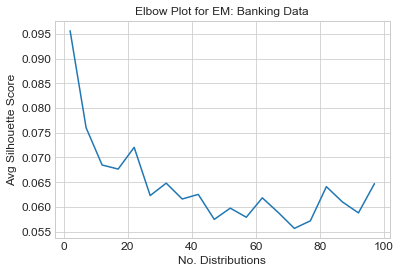

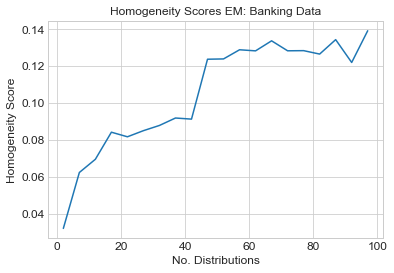

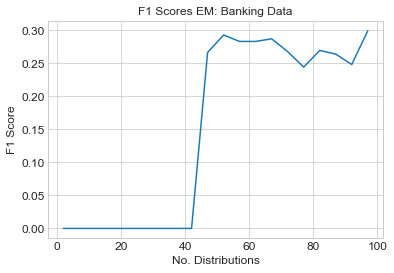

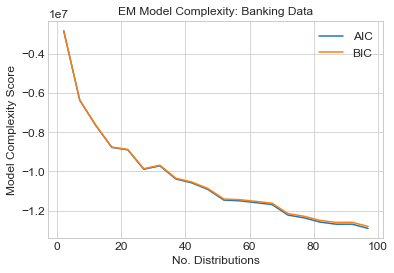

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   14.44
No. Iterations to Converge: 17
Log-likelihood Lower Bound: 160.71
F1 Score:  0.28
Accuracy:  0.90     AUC:       0.58
Precision: 0.66     Recall:    0.18
*****************************************************


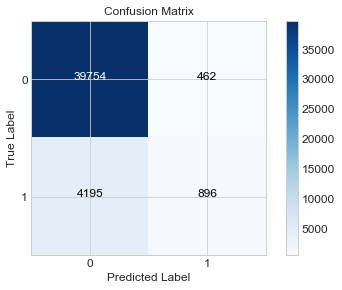

In [15]:
phishX,phishY,bankX,bankY = import_data()
X_train, X_test, y_train, y_test = train_test_split(np.array(bankX),np.array(bankY), test_size=0.25)
run_EM(X_train,y_train,'Banking Data')
em = EM(n_components=41,covariance_type='diag',n_init=1,warm_start=True,random_state=100)
evaluate_EM(em,bankX,bankY)
df = pd.DataFrame(em.means_)
df.to_csv("Banking EM Component Means.csv")


# 4. Dimensionality Reduction

This section will implement 4 different dimensionality reduction techniques on both the phishing and the banking dataset. Then, k-means and EM clustering will be performed for each (dataset * dim_reduction) combination to see how the clustering compares with using the full datasets. The 4 dimensionality reduction techniques are:
- Principal Components Analysis (PCA). Optimal number of PC chosen by inspecting % variance explained and the eigenvalues.
- Independent Components Analysis (ICA). Optimal number of IC chosen by inspecting kurtosis.
- Random Components Analysis (RCA) (otherwise known as Randomized Projections). Optimal number of RC chosen by inspecting reconstruction error.
- Random Forest Classifier (RFC). Optimal number of components chosen by feature importance.

In [16]:
from sklearn.decomposition import PCA, FastICA as ICA
from sklearn.random_projection import GaussianRandomProjection as GRP, SparseRandomProjection as RCA
from sklearn.ensemble import RandomForestClassifier as RFC
from itertools import product
from collections import defaultdict

def run_PCA(X,y,title):
    
    pca = PCA(random_state=5).fit(X) #for all components
    cum_var = np.cumsum(pca.explained_variance_ratio_)

    fig, ax1 = plt.subplots()
    ax1.plot(list(range(len(pca.explained_variance_ratio_))), cum_var, 'b-')
    ax1.set_xlabel('Principal Components')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel('Cumulative Explained Variance Ratio', color='b')
    ax1.tick_params('y', colors='b')
    plt.grid(False)

    ax2 = ax1.twinx()
    ax2.plot(list(range(len(pca.singular_values_))), pca.singular_values_, 'm-')
    ax2.set_ylabel('Eigenvalues', color='m')
    ax2.tick_params('y', colors='m')
    plt.grid(False)

    plt.title("PCA Explained Variance and Eigenvalues: "+ title)
    fig.tight_layout()
    plt.show()
    
def run_ICA(X,y,title):
    
    dims = list(np.arange(2,(X.shape[1]-1),3))
    dims.append(X.shape[1])
    ica = ICA(random_state=5)
    kurt = []

    for dim in dims:
        ica.set_params(n_components=dim)
        tmp = ica.fit_transform(X)
        tmp = pd.DataFrame(tmp)
        tmp = tmp.kurt(axis=0)
        kurt.append(tmp.abs().mean())

    plt.figure()
    plt.title("ICA Kurtosis: "+ title)
    plt.xlabel("Independent Components")
    plt.ylabel("Avg Kurtosis Across IC")
    plt.plot(dims, kurt, 'b-')
    plt.grid(False)
    plt.show()

def run_RCA(X,y,title):
    
    dims = list(np.arange(2,(X.shape[1]-1),3))
    dims.append(X.shape[1])
    tmp = defaultdict(dict)

    for i,dim in product(range(5),dims):
        rp = RCA(random_state=i, n_components=dim)
        tmp[dim][i] = pairwiseDistCorr(rp.fit_transform(X), X)
    tmp = pd.DataFrame(tmp).T
    mean_recon = tmp.mean(axis=1).tolist()
    std_recon = tmp.std(axis=1).tolist()


    fig, ax1 = plt.subplots()
    ax1.plot(dims,mean_recon, 'b-')
    ax1.set_xlabel('Random Components')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel('Mean Reconstruction Correlation', color='b')
    ax1.tick_params('y', colors='b')
    plt.grid(False)

    ax2 = ax1.twinx()
    ax2.plot(dims,std_recon, 'm-')
    ax2.set_ylabel('STD Reconstruction Correlation', color='m')
    ax2.tick_params('y', colors='m')
    plt.grid(False)

    plt.title("Random Components for 5 Restarts: "+ title)
    fig.tight_layout()
    plt.show()
    
def run_RFC(X,y,df_original):
    rfc = RFC(n_estimators=500,min_samples_leaf=round(len(X)*.01),random_state=5,n_jobs=-1)
    imp = rfc.fit(X,y).feature_importances_ 
    imp = pd.DataFrame(imp,columns=['Feature Importance'],index=df_original.columns[2::])
    imp.sort_values(by=['Feature Importance'],inplace=True,ascending=False)
    imp['Cum Sum'] = imp['Feature Importance'].cumsum()
    imp = imp[imp['Cum Sum']<=0.95]
    top_cols = imp.index.tolist()
    return imp, top_cols

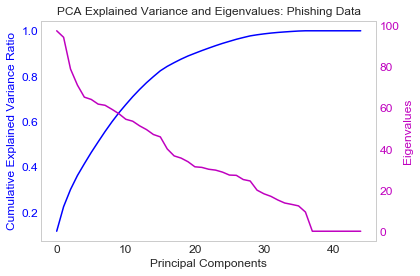

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


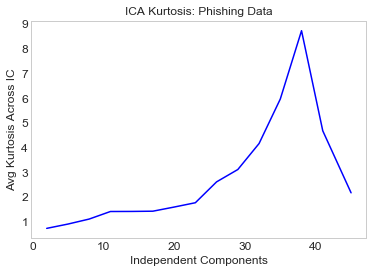

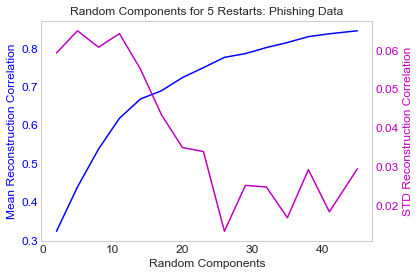

In [17]:
phishX,phishY,bankX,bankY = import_data()
run_PCA(phishX,phishY,"Phishing Data")
run_ICA(phishX,phishY,"Phishing Data")
run_RCA(phishX,phishY,"Phishing Data")
imp_phish, topcols_phish = run_RFC(phishX,phishY,df_phish)

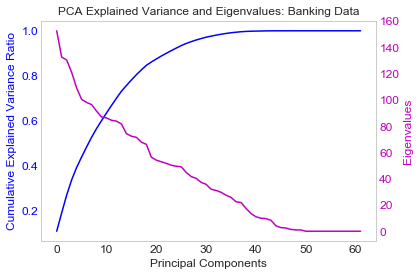

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:121: ConvergenceWarning: FastICA did not converge. Cons

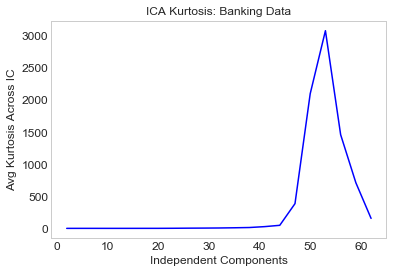

In [18]:
phishX,phishY,bankX,bankY = import_data()
X_train, X_test, y_train, y_test = train_test_split(np.array(bankX),np.array(bankY), test_size=0.2)
run_PCA(X_train,bankY,"Banking Data")
run_ICA(X_train,bankY,"Banking Data")
imp_bank, topcols_bank = run_RFC(X_train,y_train,df_bank)


Recreating Clustering Experiment (k-means and EM) for phishing data.

In [19]:
phishX,phishY,bankX,bankY = import_data()
imp_phish, topcols_phish = run_RFC(phishX,phishY,df_phish)
pca_phish = PCA(n_components=22,random_state=5).fit_transform(phishX)
ica_phish = ICA(n_components=38,random_state=5).fit_transform(phishX)
rca_phish = ICA(n_components=29,random_state=5).fit_transform(phishX)
rfc_phish = df_phish[topcols_phish]
rfc_phish = np.array(rfc_phish.values,dtype='int64')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


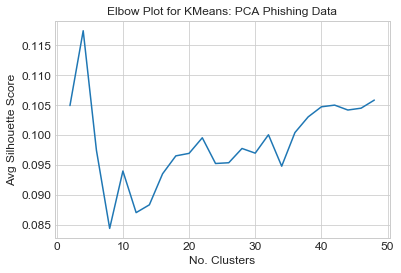

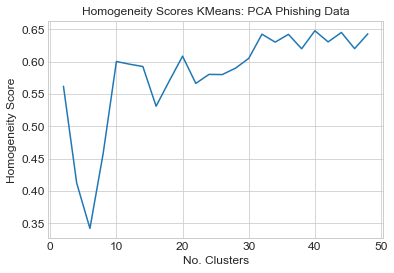

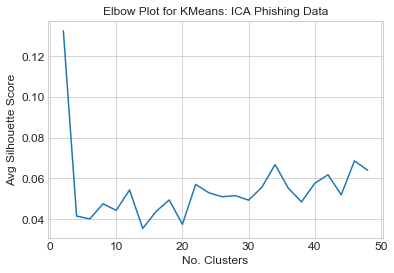

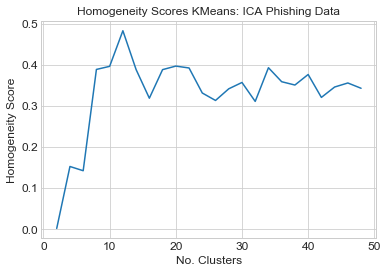

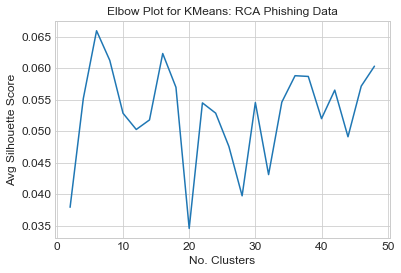

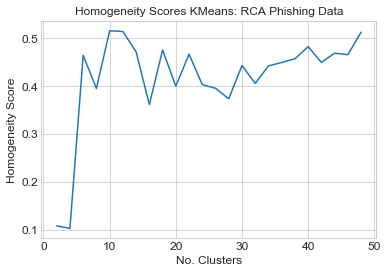

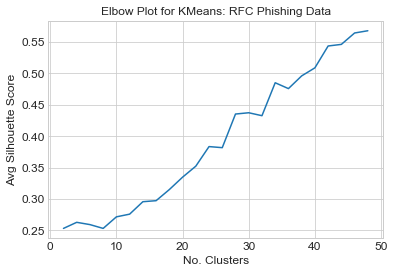

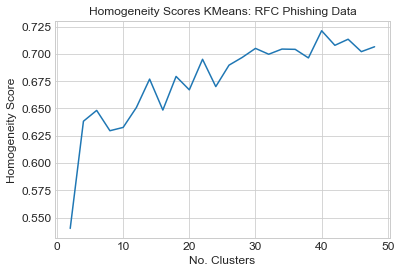

In [20]:
run_kmeans(pca_phish,phishY,'PCA Phishing Data')
run_kmeans(ica_phish,phishY,'ICA Phishing Data')
run_kmeans(rca_phish,phishY,'RCA Phishing Data')
run_kmeans(rfc_phish,phishY,'RFC Phishing Data')

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   1.35
No. Iterations to Converge: 25
F1 Score:  0.90
Accuracy:  0.89     AUC:       0.89
Precision: 0.91     Recall:    0.90
*****************************************************


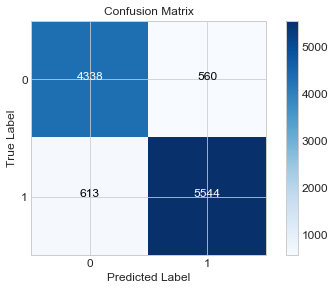

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   1.31
No. Iterations to Converge: 24
F1 Score:  0.86
Accuracy:  0.83     AUC:       0.82
Precision: 0.80     Recall:    0.93
*****************************************************


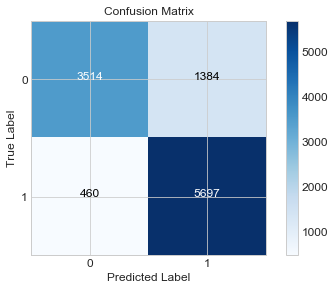

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   1.01
No. Iterations to Converge: 19
F1 Score:  0.86
Accuracy:  0.84     AUC:       0.83
Precision: 0.83     Recall:    0.89
*****************************************************


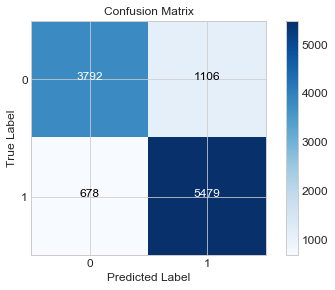

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.43
No. Iterations to Converge: 7
F1 Score:  0.92
Accuracy:  0.91     AUC:       0.91
Precision: 0.91     Recall:    0.93
*****************************************************


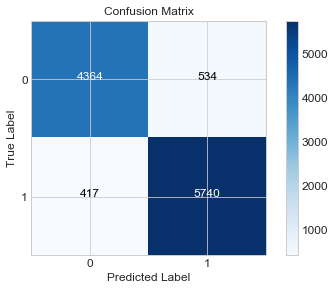

In [21]:
evaluate_kmeans(KMeans(n_clusters=14,n_init=10,random_state=100,n_jobs=-1),pca_phish,phishY)
evaluate_kmeans(KMeans(n_clusters=12,n_init=10,random_state=100,n_jobs=-1),ica_phish,phishY)
evaluate_kmeans(KMeans(n_clusters=10,n_init=10,random_state=100,n_jobs=-1),rca_phish,phishY)
evaluate_kmeans(KMeans(n_clusters=14,n_init=10,random_state=100,n_jobs=-1),rfc_phish,phishY)

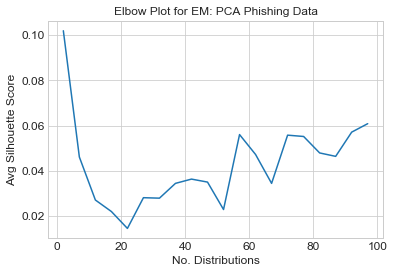

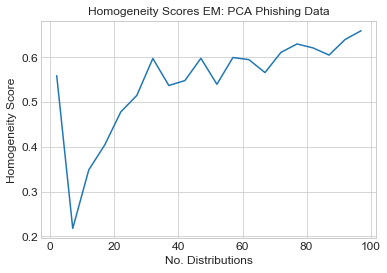

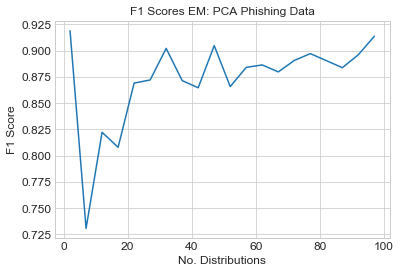

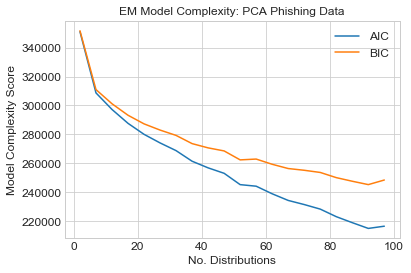

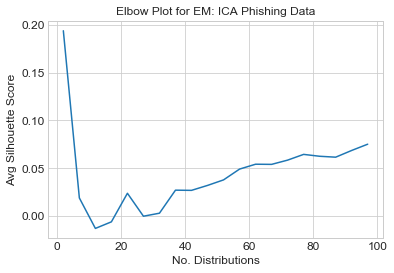

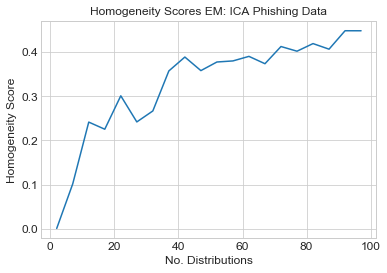

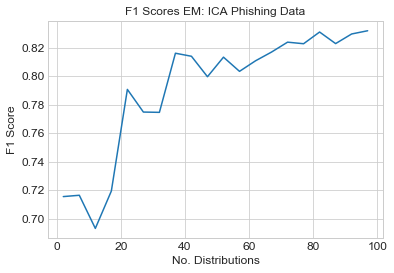

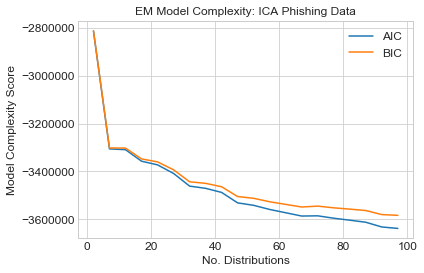

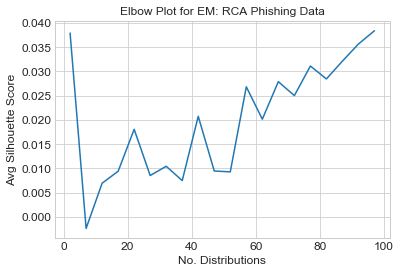

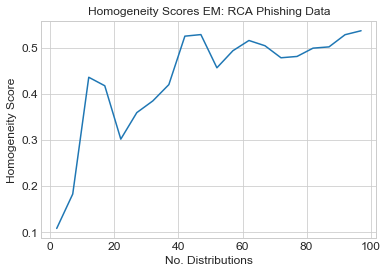

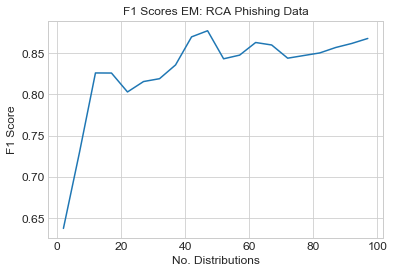

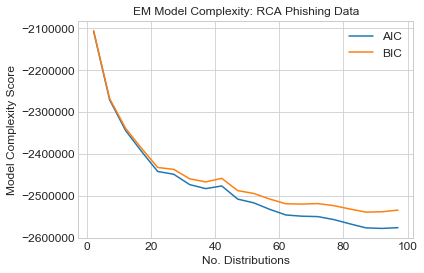

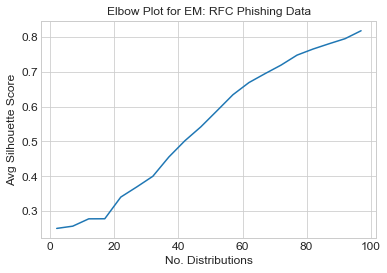

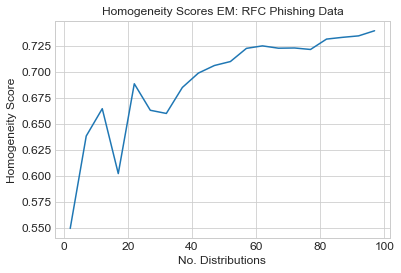

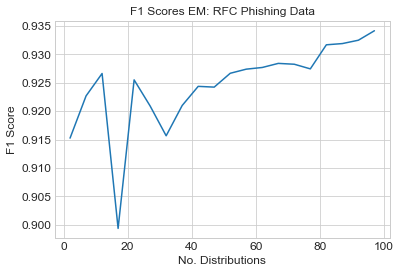

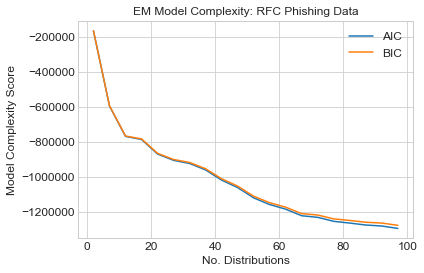

In [22]:
run_EM(pca_phish,phishY,'PCA Phishing Data')
run_EM(ica_phish,phishY,'ICA Phishing Data')
run_EM(rca_phish,phishY,'RCA Phishing Data')
run_EM(rfc_phish,phishY,'RFC Phishing Data')

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.92
No. Iterations to Converge: 39
Log-likelihood Lower Bound: -12.84
F1 Score:  0.82
Accuracy:  0.80     AUC:       0.79
Precision: 0.81     Recall:    0.83
*****************************************************


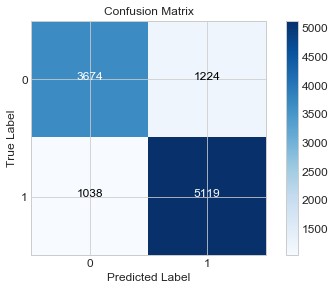

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   1.33
No. Iterations to Converge: 23
Log-likelihood Lower Bound: 153.52
F1 Score:  0.77
Accuracy:  0.72     AUC:       0.71
Precision: 0.72     Recall:    0.82
*****************************************************


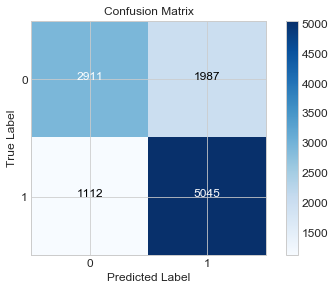

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   1.16
No. Iterations to Converge: 31
Log-likelihood Lower Bound: 111.10
F1 Score:  0.80
Accuracy:  0.77     AUC:       0.76
Precision: 0.78     Recall:    0.82
*****************************************************


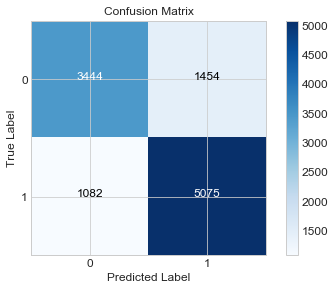

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.80
No. Iterations to Converge: 8
Log-likelihood Lower Bound: 39.43
F1 Score:  0.93
Accuracy:  0.92     AUC:       0.91
Precision: 0.92     Recall:    0.93
*****************************************************


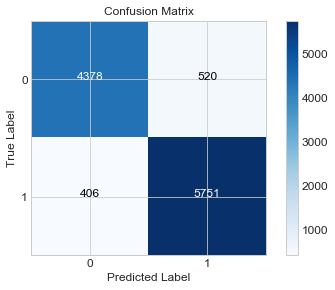

In [23]:
evaluate_EM(EM(n_components=18,covariance_type='diag',n_init=1,warm_start=True,random_state=100),pca_phish,phishY)
evaluate_EM(EM(n_components=28,covariance_type='diag',n_init=1,warm_start=True,random_state=100),ica_phish,phishY)
evaluate_EM(EM(n_components=25,covariance_type='diag',n_init=1,warm_start=True,random_state=100),rca_phish,phishY)
evaluate_EM(EM(n_components=22,covariance_type='diag',n_init=1,warm_start=True,random_state=100),rfc_phish,phishY)

Recreating Clustering Experiment (k-means and EM) for banking data.

In [24]:
pca_bank = PCA(n_components=20,random_state=5).fit_transform(X_train)
ica_bank = ICA(n_components=47,random_state=5).fit_transform(X_train)
rca_bank = ICA(n_components=39,random_state=5).fit_transform(X_train)
rfc_bank = df_bank[topcols_bank]
rfc_bank = np.array(rfc_bank.values,dtype='int64')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: Undefined

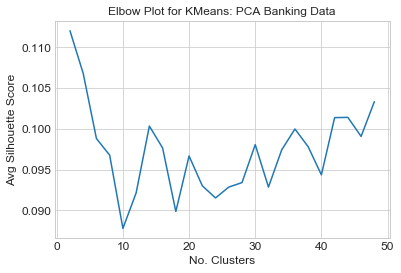

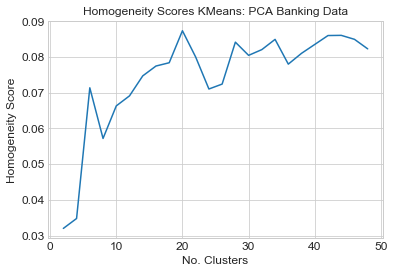

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


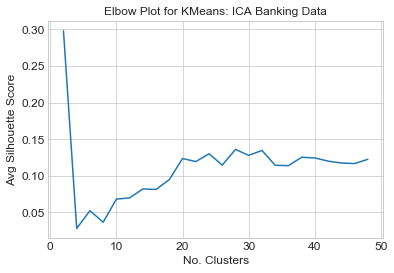

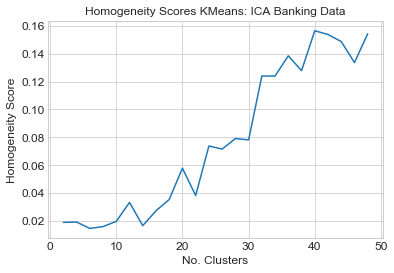

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: Undefined

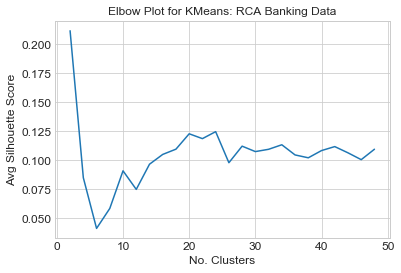

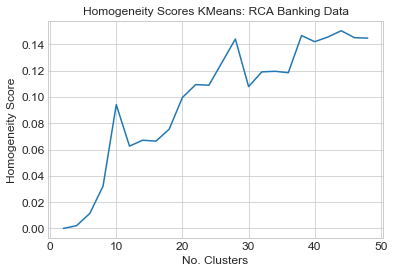

AssertionError: 

In [25]:
run_kmeans(pca_bank,y_train,'PCA Banking Data')
run_kmeans(ica_bank,y_train,'ICA Banking Data')
run_kmeans(rca_bank,y_train,'RCA Banking Data')
run_kmeans(rfc_bank,y_train,'RFC Banking Data')

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   5.39
No. Iterations to Converge: 44
F1 Score:  0.00
Accuracy:  0.89     AUC:       0.50
Precision: 0.00     Recall:    0.00
*****************************************************


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


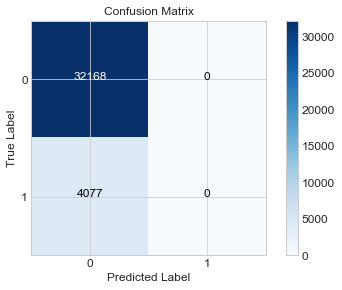

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   9.73
No. Iterations to Converge: 18
F1 Score:  0.26
Accuracy:  0.89     AUC:       0.58
Precision: 0.56     Recall:    0.17
*****************************************************


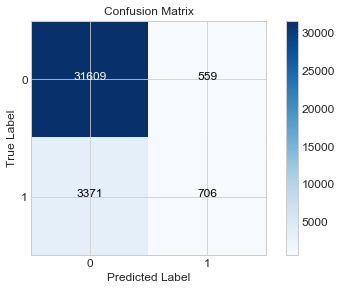

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   2.19
No. Iterations to Converge: 8
F1 Score:  0.28
Accuracy:  0.90     AUC:       0.58
Precision: 0.64     Recall:    0.18
*****************************************************


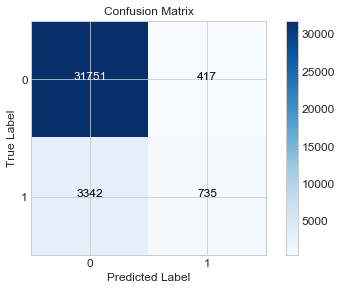

AssertionError: 

In [26]:
evaluate_kmeans(KMeans(n_clusters=20,n_init=10,random_state=100,n_jobs=-1),pca_bank,y_train)
evaluate_kmeans(KMeans(n_clusters=47,n_init=10,random_state=100,n_jobs=-1),ica_bank,y_train)
evaluate_kmeans(KMeans(n_clusters=10,n_init=10,random_state=100,n_jobs=-1),rca_bank,y_train)
evaluate_kmeans(KMeans(n_clusters=14,n_init=10,random_state=100,n_jobs=-1),rfc_bank,y_train)

In [27]:
run_EM(pca_bank,bankY,'PCA Banking Data')
run_EM(ica_bank,bankY,'ICA Banking Data')
run_EM(rca_bank,bankY,'RCA Banking Data')
run_EM(rfc_bank,bankY,'RFC Banking Data')

AssertionError: 

In [28]:
evaluate_EM(EM(n_components=18,covariance_type='diag',n_init=1,warm_start=True,random_state=100),pca_bank,bankY)
evaluate_EM(EM(n_components=28,covariance_type='diag',n_init=1,warm_start=True,random_state=100),ica_bank,bankY)
evaluate_EM(EM(n_components=25,covariance_type='diag',n_init=1,warm_start=True,random_state=100),rca_bank,bankY)
evaluate_EM(EM(n_components=22,covariance_type='diag',n_init=1,warm_start=True,random_state=100),rfc_bank,bankY)

AssertionError: 

# 5. Training Neural Network on Projected Data

This section will train a neural network on the 4 projected datasets for only the phishing data. We will examine the learning curves on the training data as well as the final network performance on the test dataset.

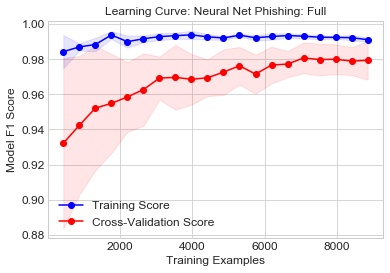

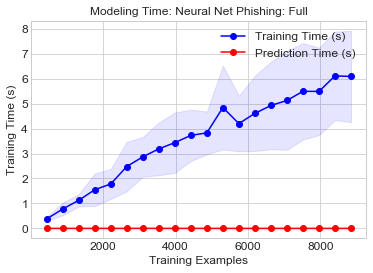

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   4.84520
Model Prediction Time (s): 0.00208

F1 Score:  0.97
Accuracy:  0.97     AUC:       0.97
Precision: 0.97     Recall:    0.98
*****************************************************


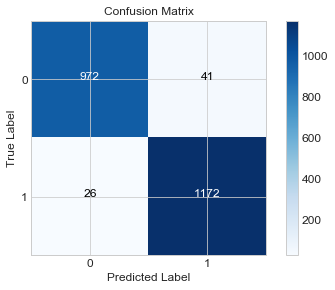

In [29]:
# Original, full dataset
X_train, X_test, y_train, y_test = train_test_split(np.array(phishX),np.array(phishY), test_size=0.20)
full_est = MLPClassifier(hidden_layer_sizes=(50,), solver='adam', activation='logistic', learning_rate_init=0.01, random_state=100)
train_samp_full, NN_train_score_full, NN_fit_time_full, NN_pred_time_full = plot_learning_curve(full_est, X_train, y_train,title="Neural Net Phishing: Full")
final_classifier_evaluation(full_est, X_train, X_test, y_train, y_test)

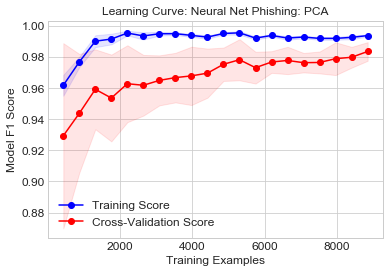

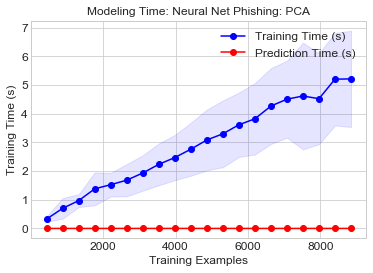

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   3.76130
Model Prediction Time (s): 0.00168

F1 Score:  0.98
Accuracy:  0.97     AUC:       0.97
Precision: 0.96     Recall:    0.99
*****************************************************


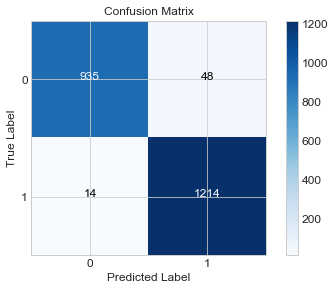

In [30]:
X_train, X_test, y_train, y_test = train_test_split(np.array(pca_phish),np.array(phishY), test_size=0.20)
pca_est = MLPClassifier(hidden_layer_sizes=(50,), solver='adam', activation='logistic', learning_rate_init=0.01, random_state=100)
train_samp_pca, NN_train_score_pca, NN_fit_time_pca, NN_pred_time_pca = plot_learning_curve(pca_est, X_train, y_train,title="Neural Net Phishing: PCA")
final_classifier_evaluation(pca_est, X_train, X_test, y_train, y_test)

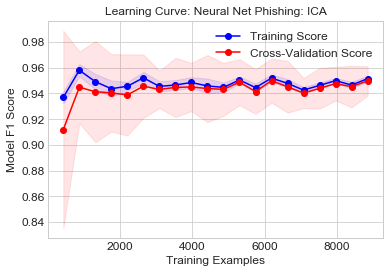

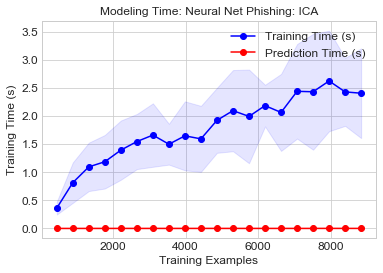

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   1.54799
Model Prediction Time (s): 0.00262

F1 Score:  0.95
Accuracy:  0.94     AUC:       0.94
Precision: 0.94     Recall:    0.96
*****************************************************


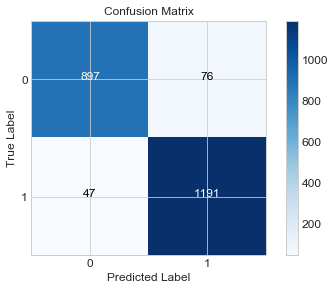

In [31]:
X_train, X_test, y_train, y_test = train_test_split(np.array(ica_phish),np.array(phishY), test_size=0.20)
ica_est = MLPClassifier(hidden_layer_sizes=(50,), solver='adam', activation='logistic', learning_rate_init=0.01, random_state=100)
train_samp_ica, NN_train_score_ica, NN_fit_time_ica, NN_pred_time_ica = plot_learning_curve(ica_est, X_train, y_train,title="Neural Net Phishing: ICA")
final_classifier_evaluation(ica_est, X_train, X_test, y_train, y_test)

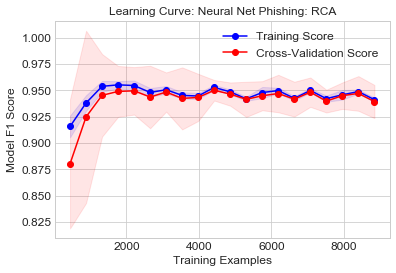

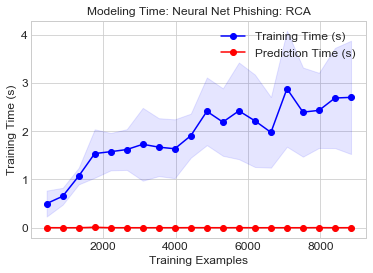

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   2.92278
Model Prediction Time (s): 0.00169

F1 Score:  0.95
Accuracy:  0.94     AUC:       0.94
Precision: 0.94     Recall:    0.96
*****************************************************


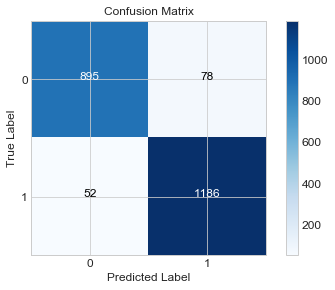

In [32]:
X_train, X_test, y_train, y_test = train_test_split(np.array(rca_phish),np.array(phishY), test_size=0.20)
rca_est = MLPClassifier(hidden_layer_sizes=(50,), solver='adam', activation='logistic', learning_rate_init=0.01, random_state=100)
train_samp_rca, NN_train_score_rca, NN_fit_time_rca, NN_pred_time_rca = plot_learning_curve(rca_est, X_train, y_train,title="Neural Net Phishing: RCA")
final_classifier_evaluation(rca_est, X_train, X_test, y_train, y_test)

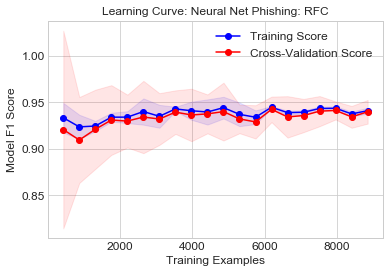

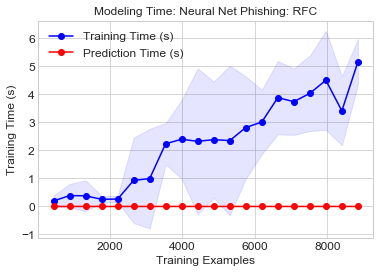

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   3.52672
Model Prediction Time (s): 0.00193

F1 Score:  0.93
Accuracy:  0.93     AUC:       0.93
Precision: 0.92     Recall:    0.95
*****************************************************


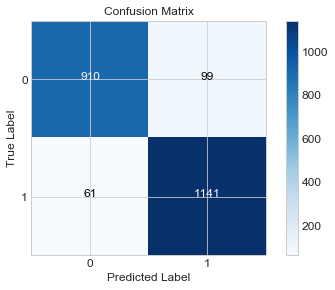

In [33]:
X_train, X_test, y_train, y_test = train_test_split(np.array(rfc_phish),np.array(phishY), test_size=0.20)
rfc_est = MLPClassifier(hidden_layer_sizes=(50,), solver='adam', activation='logistic', learning_rate_init=0.01, random_state=100)
train_samp_rfc, NN_train_score_rfc, NN_fit_time_rfc, NN_pred_time_rfc = plot_learning_curve(rfc_est, X_train, y_train,title="Neural Net Phishing: RFC")
final_classifier_evaluation(rfc_est, X_train, X_test, y_train, y_test)

# 6. Model Comparison Plots

Let's define and call a function that will plot training times and learning rates for the 4 different NN models so that we can compare across the classifiers for the same dataset.

In [34]:
def compare_fit_time(n,full_fit,pca_fit,ica_fit,rca_fit,rfc_fit,title):
    
    plt.figure()
    plt.title("Model Training Times: " + title)
    plt.xlabel("Training Examples")
    plt.ylabel("Model Training Time (s)")
    plt.plot(n, full_fit, '-', color="k", label="Full Dataset")
    plt.plot(n, pca_fit, '-', color="b", label="PCA")
    plt.plot(n, ica_fit, '-', color="r", label="ICA")
    plt.plot(n, rca_fit, '-', color="g", label="RCA")
    plt.plot(n, rfc_fit, '-', color="m", label="RFC")
    plt.legend(loc="best")
    plt.show()
    
def compare_pred_time(n,full_pred, pca_pred, ica_pred, rca_pred, rfc_pred, title):
    
    plt.figure()
    plt.title("Model Prediction Times: " + title)
    plt.xlabel("Training Examples")
    plt.ylabel("Model Prediction Time (s)")
    plt.plot(n, full_pred, '-', color="k", label="Full Dataset")
    plt.plot(n, pca_pred, '-', color="b", label="PCA")
    plt.plot(n, ica_pred, '-', color="r", label="ICA")
    plt.plot(n, rca_pred, '-', color="g", label="RCA")
    plt.plot(n, rfc_pred, '-', color="m", label="RFC")
    plt.legend(loc="best")
    plt.show()


def compare_learn_time(n,full_learn, pca_learn, ica_learn, rca_learn, rfc_learn, title):
    
    plt.figure()
    plt.title("Model Learning Rates: " + title)
    plt.xlabel("Training Examples")
    plt.ylabel("Model F1 Score")
    plt.plot(n, full_learn, '-', color="k", label="Full Dataset")
    plt.plot(n, pca_learn, '-', color="b", label="PCA")
    plt.plot(n, ica_learn, '-', color="r", label="ICA")
    plt.plot(n, rca_learn, '-', color="g", label="RCA")
    plt.plot(n, rfc_learn, '-', color="m", label="RFC")
    plt.legend(loc="best")
    plt.show() 

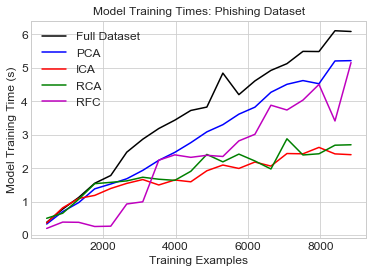

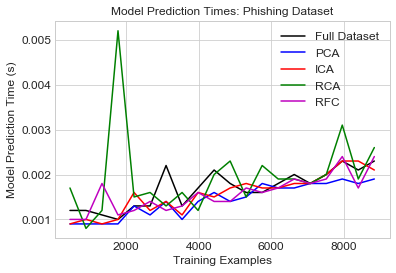

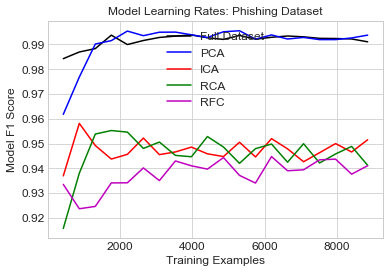

In [35]:
compare_fit_time(train_samp_full, NN_fit_time_full, NN_fit_time_pca, NN_fit_time_ica, 
                 NN_fit_time_rca, NN_fit_time_rfc, 'Phishing Dataset')              
compare_pred_time(train_samp_full, NN_pred_time_full, NN_pred_time_pca, NN_pred_time_ica, 
                 NN_pred_time_rca, NN_pred_time_rfc, 'Phishing Dataset')   
compare_learn_time(train_samp_full, NN_train_score_full, NN_train_score_pca, NN_train_score_ica, 
                 NN_train_score_rca, NN_train_score_rfc, 'Phishing Dataset')  

# 7. Training Neural Network on Projected Data with Cluster Labels

This section will train a neural network on the 4 projected datasets for only the phishing data. The difference in this section is that we now add cluster labels from both k-means and EM (after 1-hot encoding) to the reduced datasets. We will examine the learning curves on the training data as well as the final network performance on the test dataset.

In [36]:
def addclusters(X,km_lables,em_lables):
    
    df = pd.DataFrame(X)
    df['KM Cluster'] = km_labels
    df['EM Cluster'] = em_labels
    col_1hot = ['KM Cluster', 'EM Cluster']
    df_1hot = df[col_1hot]
    df_1hot = pd.get_dummies(df_1hot).astype('category')
    df_others = df.drop(col_1hot,axis=1)
    df = pd.concat([df_others,df_1hot],axis=1)
    new_X = np.array(df.values,dtype='int64')   
    
    return new_X

In [37]:
km = KMeans(n_clusters=9,n_init=10,random_state=100,n_jobs=-1).fit(phishX)
km_labels = km.labels_
em = EM(n_components=24,covariance_type='diag',n_init=1,warm_start=True,random_state=100).fit(phishX)
em_labels = em.predict(phishX)

clust_full = addclusters(phishX,km_labels,em_labels)
clust_pca = addclusters(pca_phish,km_labels,em_labels)
clust_ica = addclusters(ica_phish,km_labels,em_labels)
clust_rca = addclusters(rca_phish,km_labels,em_labels)
clust_rfc = addclusters(rfc_phish,km_labels,em_labels)

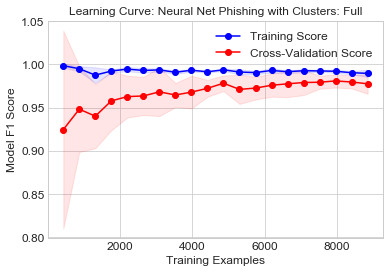

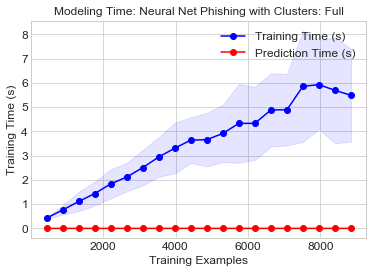

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   4.08147
Model Prediction Time (s): 0.00196

F1 Score:  0.97
Accuracy:  0.97     AUC:       0.97
Precision: 0.97     Recall:    0.98
*****************************************************


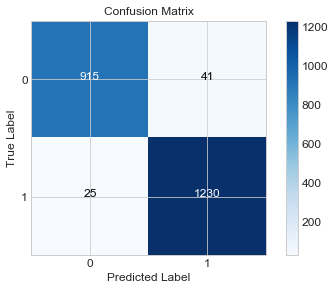

In [38]:
# Original, full dataset
X_train, X_test, y_train, y_test = train_test_split(np.array(clust_full),np.array(phishY), test_size=0.20)
full_est = MLPClassifier(hidden_layer_sizes=(50,), solver='adam', activation='logistic', learning_rate_init=0.01, random_state=100)
train_samp_full, NN_train_score_full, NN_fit_time_full, NN_pred_time_full = plot_learning_curve(full_est, X_train, y_train,title="Neural Net Phishing with Clusters: Full")
final_classifier_evaluation(full_est, X_train, X_test, y_train, y_test)

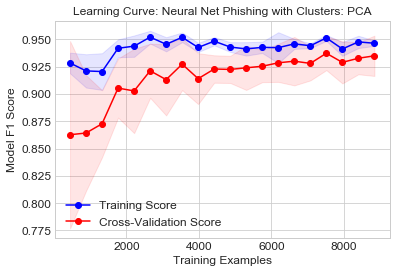

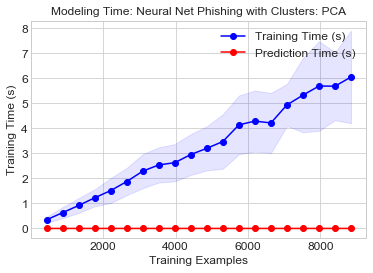

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   4.42146
Model Prediction Time (s): 0.00159

F1 Score:  0.93
Accuracy:  0.93     AUC:       0.92
Precision: 0.93     Recall:    0.94
*****************************************************


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


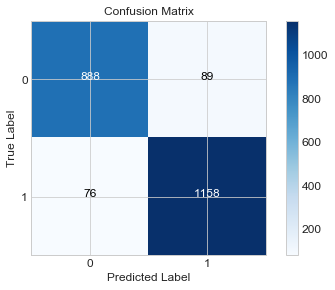

In [39]:
X_train, X_test, y_train, y_test = train_test_split(np.array(clust_pca),np.array(phishY), test_size=0.20)
pca_est = MLPClassifier(hidden_layer_sizes=(50,), solver='adam', activation='logistic', learning_rate_init=0.01, random_state=100)
train_samp_pca, NN_train_score_pca, NN_fit_time_pca, NN_pred_time_pca = plot_learning_curve(pca_est, X_train, y_train,title="Neural Net Phishing with Clusters: PCA")
final_classifier_evaluation(pca_est, X_train, X_test, y_train, y_test)

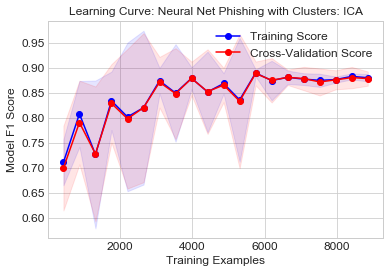

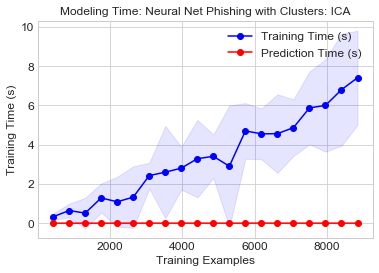

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   4.25807
Model Prediction Time (s): 0.00166

F1 Score:  0.89
Accuracy:  0.86     AUC:       0.85
Precision: 0.82     Recall:    0.97
*****************************************************


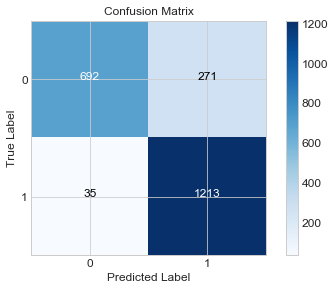

In [40]:
X_train, X_test, y_train, y_test = train_test_split(np.array(clust_ica),np.array(phishY), test_size=0.20)
ica_est = MLPClassifier(hidden_layer_sizes=(50,), solver='adam', activation='logistic', learning_rate_init=0.01, random_state=100)
train_samp_ica, NN_train_score_ica, NN_fit_time_ica, NN_pred_time_ica = plot_learning_curve(ica_est, X_train, y_train,title="Neural Net Phishing with Clusters: ICA")
final_classifier_evaluation(ica_est, X_train, X_test, y_train, y_test)

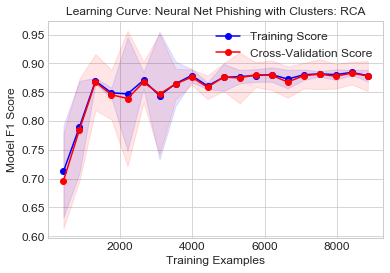

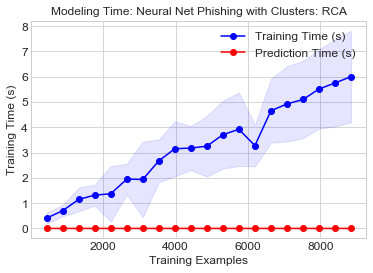

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   4.97517
Model Prediction Time (s): 0.00279

F1 Score:  0.88
Accuracy:  0.85     AUC:       0.84
Precision: 0.81     Recall:    0.96
*****************************************************


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


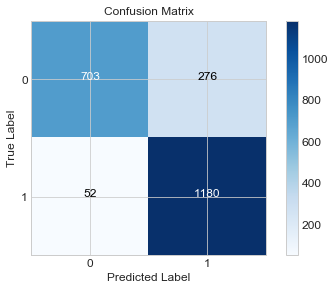

In [41]:
X_train, X_test, y_train, y_test = train_test_split(np.array(clust_rca),np.array(phishY), test_size=0.20)
rca_est = MLPClassifier(hidden_layer_sizes=(50,), solver='adam', activation='logistic', learning_rate_init=0.01, random_state=100)
train_samp_rca, NN_train_score_rca, NN_fit_time_rca, NN_pred_time_rca = plot_learning_curve(rca_est, X_train, y_train,title="Neural Net Phishing with Clusters: RCA")
final_classifier_evaluation(rca_est, X_train, X_test, y_train, y_test)

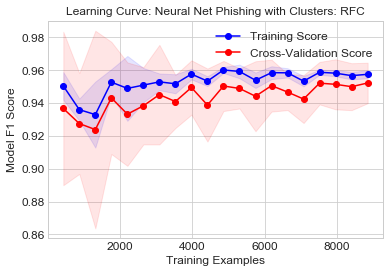

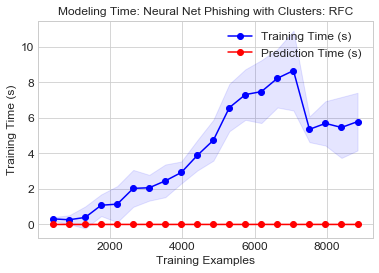

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   4.27289
Model Prediction Time (s): 0.00177

F1 Score:  0.94
Accuracy:  0.94     AUC:       0.93
Precision: 0.92     Recall:    0.96
*****************************************************


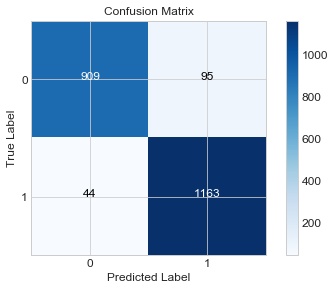

In [42]:
X_train, X_test, y_train, y_test = train_test_split(np.array(clust_rfc),np.array(phishY), test_size=0.20)
rfc_est = MLPClassifier(hidden_layer_sizes=(50,), solver='adam', activation='logistic', learning_rate_init=0.01, random_state=100)
train_samp_rfc, NN_train_score_rfc, NN_fit_time_rfc, NN_pred_time_rfc = plot_learning_curve(rfc_est, X_train, y_train,title="Neural Net Phishing with Clusters: RFC")
final_classifier_evaluation(rfc_est, X_train, X_test, y_train, y_test)

Evaluate new datasets with cluster labels added.

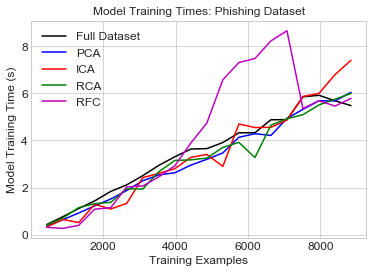

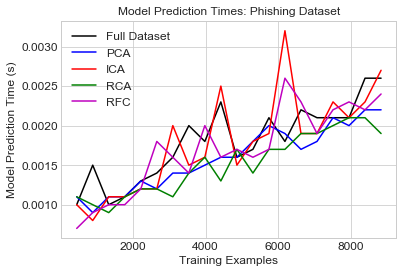

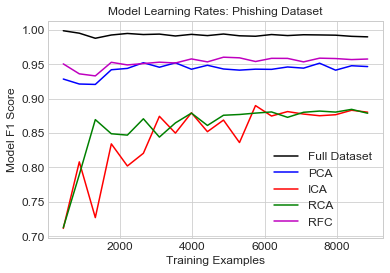

In [43]:
compare_fit_time(train_samp_full, NN_fit_time_full, NN_fit_time_pca, NN_fit_time_ica, 
                 NN_fit_time_rca, NN_fit_time_rfc, 'Phishing Dataset')              
compare_pred_time(train_samp_full, NN_pred_time_full, NN_pred_time_pca, NN_pred_time_ica, 
                 NN_pred_time_rca, NN_pred_time_rfc, 'Phishing Dataset')   
compare_learn_time(train_samp_full, NN_train_score_full, NN_train_score_pca, NN_train_score_ica, 
                 NN_train_score_rca, NN_train_score_rfc, 'Phishing Dataset')  